# Case txp

> In this case study, we are exploring deep learning interpretability on BSI prognosis, before, during and after training a CNN model on multi-variate time series medical record.
 
> we use hourly aggregated physiological data and lab results from 10,000 ICU patients. 1824 positive events and 31496 control group events are generated from the population. 

> we use 25 features selected by domain knowledge, 96 hours prior to the blood culture acquisition to classify positive test results from the control group -- negative test results and 4 days of randomly sliced baseline patient data.  


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

In [2]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'
# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_fwd'

# initiate dataframe to return
all_df=None
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
print(bsi_stream.engineer.variable_dict)
print(bsi_stream.engineer.csv_source_dict)

Success: Querier has initiated a csv source dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_fwd/meta_data/csv_source_dict_demo.json
Success: Querier has initiated a variable dictionary in:/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_fwd/meta_data/variable_dict_demo.json
Unable to read sql source dictionary. Use Querier.update_sql_source_dict() to build one.
{'__uid': {'src_names': ['id', 'ID', 'subject_id', 'subject_id', 'oldid'], 'label': 'subject id', 'unique_per_sbj': True}, '__time': {'src_names': ['tsa', 'timeMinutes'], 'label': 'Time since admission', 'unit': 'minute'}, '__anchor': {'src_names': ['True_positive', 'True positive', 'label'], 'label': 'episode anchor', 'unique_per_sbj': False, 'shuffle': ['__nbc'], 'factor': {'levels': {'__nbc': ['nan'], '__ctm': ['contaminant'], '__neg': ['0', '0.0', 'negative'], '__pos': ['1', '1.0', 'true_positive']}, 'impute_per_sbj': {'nan_level': '__nbc'}}}, 'y': {'output': True, 'src_names': 

In [3]:
# bsi_stream.querier.create_csv_pool(csv_pool_dir = csv_pool_path,
#                                   source_key="uvanewbc",
#                                   file_key="all",
#                                   sep="_")

In [4]:
# bsi_stream.querier.create_csv_pool(csv_pool_dir = csv_pool_path,
#                                   source_key="uvanewnbc",
#                                   file_key="all",
#                                   sep="_")

In [5]:
## nbc (baseline) group 
# # define an episode (notice that the engineer now has new attributes)
# bsi_stream.engineer.DefineEpisode(input_time_len=1*60, # using vital signs and labs 4 days prior to a culture 
#                                   output_time_len=(4*24-1)*60, # predict one time unit into the future
#                                   time_resolution=60, # aggregate minutely data to one row per hour 
#                                   time_lag=0,  # no time lag between predictors and response
#                                   anchor_gap=4*24*60) # the minimum distance between two episodes

In [6]:
## nbc group 
bsi_stream.engineer.DefineEpisode(input_time_len=2*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=2*24*60, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

Success! Engineer has updated attributes --- episode. 


In [7]:
df_nbc = pd.read_csv("/Users/jiaxingqiu/Documents/CAMA_projects/BSI/2016_2021/data_ml/bsi_new_deidentified_nbc.csv")

In [8]:
id_list = list(df_nbc['id'].unique())[15000:20000]
df_nbc_now = df_nbc.loc[df_nbc.id.isin(id_list),:]

In [9]:
df_nbc_now.shape

(589851, 66)

In [10]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              nsbj = 50, # number of subjects / patients to sample from the pool 
                              replace = False, # sample with replacement or not 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0.1, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='none', # imputation on predictors
                              impute_output='none',# imputation on response (no need in BSI project)
                              sep="_", 
                              return_episode=True,
                              df_raw=df_nbc_now)


Engineer is sampling without replacement --- 
Just kidding :) Engineer is using external tabular data you input!
-- __time fixed
-- __anchor fixed
-- y fixed
--- fix upper boundary for age by 90.0
--- fix lower boundary for age by 18.03
-- age fixed
--- fix upper boundary for albumin by 4.9
--- fix lower boundary for albumin by 1.2
-- albumin fixed
--- fix upper boundary for alp by 1000.0
--- fix lower boundary for alp by 18.0
-- alp fixed
--- fix upper boundary for alt by 2500.0
--- fix lower boundary for alt by 6.0
-- alt fixed
--- fix upper boundary for ast by 2500.0
--- fix lower boundary for ast by 8.0
-- ast fixed
--- fix upper boundary for bicarbonate by 50.8
--- fix lower boundary for bicarbonate by 5.8
-- bicarbonate fixed
--- fix upper boundary for bun by 150.0
--- fix lower boundary for bun by 2.0
-- bun fixed
--- fix upper boundary for calcium by 13.89455
--- fix lower boundary for calcium by 5.2
-- calcium fixed
--- fix upper boundary for chloride by 137.0
--- fix lower bo

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7449066.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7396152.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7945053.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8014710.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8166297.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7515312.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7916751.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7942728.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8401449.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7978314.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8227002.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7789047.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8410380.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7570230.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7745949.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8077677.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8073138.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7672500.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7552326.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7591029.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7942065.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8351229.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8268309.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7438947.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7744344.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7766688.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7627947.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7961103.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7845318.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7770387.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7748622.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7949919.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7878162.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8229450.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8356380.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7846662.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8271411.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7858431.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8371884.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7447425.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8337867.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7995411.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7889199.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8174994.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7684944.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7900488.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8293455.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7977285.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7663182.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8246946.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7605645.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8043312.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8024250.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8044014.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8075004.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8079960.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8125797.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8267907.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8106411.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8170941.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7859613.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7698642.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7768113.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7960044.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7894233.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7787823.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7812273.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7968396.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8392131.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7839363.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7775907.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7815630.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7899876.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7931226.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8338221.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8373600.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7587159.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7557375.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7621590.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7891845.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7905312.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8184207.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8008122.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8223798.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7692414.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7766427.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8290422.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7965627.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8092032.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8112945.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8198037.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8111091.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7575051.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7396407.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7950261.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7691880.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7937262.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8016123.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7760511.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7802679.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7754088.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7809657.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8118132.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8021916.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7469217.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7635075.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7611180.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7824384.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7789926.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8000412.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8166123.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8046432.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7993158.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7476720.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7487976.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8187552.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7811310.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7677213.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7696395.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8108700.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8261283.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7587672.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7937046.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7874301.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8196567.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8056392.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8074974.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8288067.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7653855.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7783035.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8066067.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7523082.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8006814.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7727733.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7917477.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7857837.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7851834.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8002320.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7816857.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7874184.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8057952.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7909089.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8023965.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8235171.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7706436.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7861353.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8401995.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7849176.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8001612.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7498806.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8058735.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7642185.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7497702.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8275041.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7897299.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7678950.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7732131.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7846869.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7915611.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7744584.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8103570.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8290011.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8294067.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7917582.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8056836.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7871094.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8222667.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7698405.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7748124.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8054889.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8022021.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7570422.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7869081.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7558710.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8225892.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7732629.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8293398.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7833672.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8068299.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7865445.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7912536.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7817466.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8300343.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7689873.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8279256.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7698513.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8167161.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8239092.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8370711.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7663188.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7857171.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7936305.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7970205.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8327292.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7508349.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8068155.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8063724.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8327676.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7482147.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8009103.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7939791.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7746180.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7809990.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7628043.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8220399.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7870182.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7991292.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7868898.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8019654.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7881888.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8109747.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7738593.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7863510.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8102754.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7980291.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8039307.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7843536.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8123076.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8213634.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7526451.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7406268.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7674819.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7703670.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8410599.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7961943.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8037297.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7585503.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8381637.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7875087.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7982772.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8257368.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7649190.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8168709.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7447554.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8091363.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7558857.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8066250.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8091549.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7515687.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7481193.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8056764.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8245899.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8005995.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8113197.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7991181.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7669905.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8015394.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8110782.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8045082.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7744446.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7710570.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8103339.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7814145.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8187480.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7864767.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8190255.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7505610.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8391270.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7693047.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8094039.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8342100.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8255559.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8023302.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8068311.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8380614.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7899795.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7787475.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7841949.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7773885.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7666539.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7920567.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7921734.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7872129.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7949130.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8343435.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8117982.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8297898.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8077938.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8303091.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8168364.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7938810.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7447392.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8390724.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7801728.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7854759.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8179500.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7722684.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8404653.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7690701.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7461813.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7717779.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8218071.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7677408.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7675758.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7794771.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7761837.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7886700.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7416435.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7677219.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8119542.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8347971.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8206752.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7779408.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8016870.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8292597.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7582416.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7663482.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7862673.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8199162.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8046300.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7855137.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7388559.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7711164.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8027076.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7779804.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7551663.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7738056.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8090418.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8178876.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8249046.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8013393.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8006094.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8019804.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7866858.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7555362.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8387691.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8181588.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8340654.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7913904.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8218956.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7705662.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8193324.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7804659.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7614489.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7726494.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7995303.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8337246.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8062476.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8104698.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7555308.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7829832.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8311239.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7824615.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7890543.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8165730.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8294931.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8300265.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7995645.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7478064.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7424337.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7750989.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7941939.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8317728.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8337708.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8286075.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7554876.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7620132.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7891641.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8375337.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7987266.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7549317.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8034696.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7877781.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8014791.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8403498.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8223849.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7776495.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8380998.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7501047.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8008731.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8338518.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7794699.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8209044.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8304465.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8078337.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8179980.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8045091.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8052456.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8051949.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8121771.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7954341.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7835607.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7679580.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7749201.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7835331.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8370198.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7598472.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8216949.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7418703.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7882830.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8035122.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7653684.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7724250.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7799400.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7810875.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8406321.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7872738.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8017434.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8300916.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7462974.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7817730.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7798467.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8231451.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8049417.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7756362.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8102622.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7925508.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8295045.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7951422.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8200128.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7802199.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7613199.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7666323.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7854750.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8043969.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8042379.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7485210.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7653960.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8028885.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7718685.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7502664.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7739610.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8036802.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7428951.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7912398.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7749033.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7440369.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7404273.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7728792.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7713786.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8290770.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7675374.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7627059.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8291943.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7822503.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8370537.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7403976.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7681392.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7788480.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7861086.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8029143.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7966734.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8121396.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7657857.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8397036.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7778256.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8082135.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7891251.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8247696.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7848294.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8030211.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8069637.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7572003.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7764543.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7818540.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8054499.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7568922.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8106636.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8252007.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7682859.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7950075.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7867146.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7861824.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8102196.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8169600.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7853166.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7739376.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8064426.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7843647.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7932621.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7748754.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7922769.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7999080.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8376456.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7643511.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8021259.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8235474.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7886817.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7700199.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7673313.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8066118.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7973226.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8210232.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7771518.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7951248.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7872540.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7769796.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7534227.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8351544.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7702512.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8304378.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7977570.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8284644.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7941492.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8093538.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7547190.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8180505.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8230755.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8021457.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7761354.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7975599.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7894092.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7468317.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8065404.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7694745.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7922697.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8094663.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7823994.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8321010.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8353599.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7891713.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7686003.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7460250.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7672062.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8033202.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7890930.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7876395.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7428507.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8082279.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8172513.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8349171.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8000037.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8069787.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7712271.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7899258.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8347476.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8269242.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7720815.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8041356.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7733325.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8074902.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7954422.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7761426.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7764036.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7415832.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8176635.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7509801.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7964619.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8026131.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8061792.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8047353.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8099319.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7609740.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8044668.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8115486.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8192682.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7462692.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7473954.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7959522.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7468680.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8293620.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8006370.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7463553.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7746240.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8200377.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7729374.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8038689.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7681329.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7857114.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8054442.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7704765.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8118186.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7442742.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8290581.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7915722.0
Success! Output/responce variable mean in current sample spa

Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8232918.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_8369604.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7384707.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7923621.0
Success! Output/responce variable mean in current sample space  --- 
y___ctm    0.0
y___nbc    1.0
y___neg    0.0
y___pos    0.0
dtype: float64
--- prepare episodes for external_7716795.0
Success! Output/responce variable mean in current sample spa

In [11]:
all_df_new = pd.concat( [bsi_stream.engineer.train_df, bsi_stream.engineer.valid_df], axis=0)
all_df_new = pd.concat( [all_df_new, bsi_stream.engineer.test_df], axis=0)
print(all_df_new.groupby(['txp___yes'])['__uid'].nunique())
if all_df is None:
    all_df = all_df_new
else:
    all_df = pd.concat( [all_df, all_df_new], axis=0)
print(len(set(all_df.__uid))) 

txp___yes
0.0    4780
1.0     220
Name: __uid, dtype: int64
5000


In [12]:
all_df.to_csv("./data_bsi_txp_4d_17_21_nbc_3.csv", index=False)

In [14]:
all_df = pd.read_csv("./data_bsi_txp_4d_17_21_nbc.csv")

In [15]:
all_df_new = pd.concat( [bsi_stream.engineer.train_df, bsi_stream.engineer.valid_df], axis=0)
all_df_new = pd.concat( [all_df_new, bsi_stream.engineer.test_df], axis=0)
print(all_df_new.groupby(['txp___yes'])['__uid'].nunique())
if all_df is None:
    all_df = all_df_new
else:
    all_df = pd.concat( [all_df, all_df_new], axis=0)
print(len(set(all_df.__uid))) 

txp___yes
0.0    2998
Name: __uid, dtype: int64
7998


In [16]:
all_df.to_csv("./data_bsi_txp_4d_17_21_nbc.csv", index=False)

<AxesSubplot:>

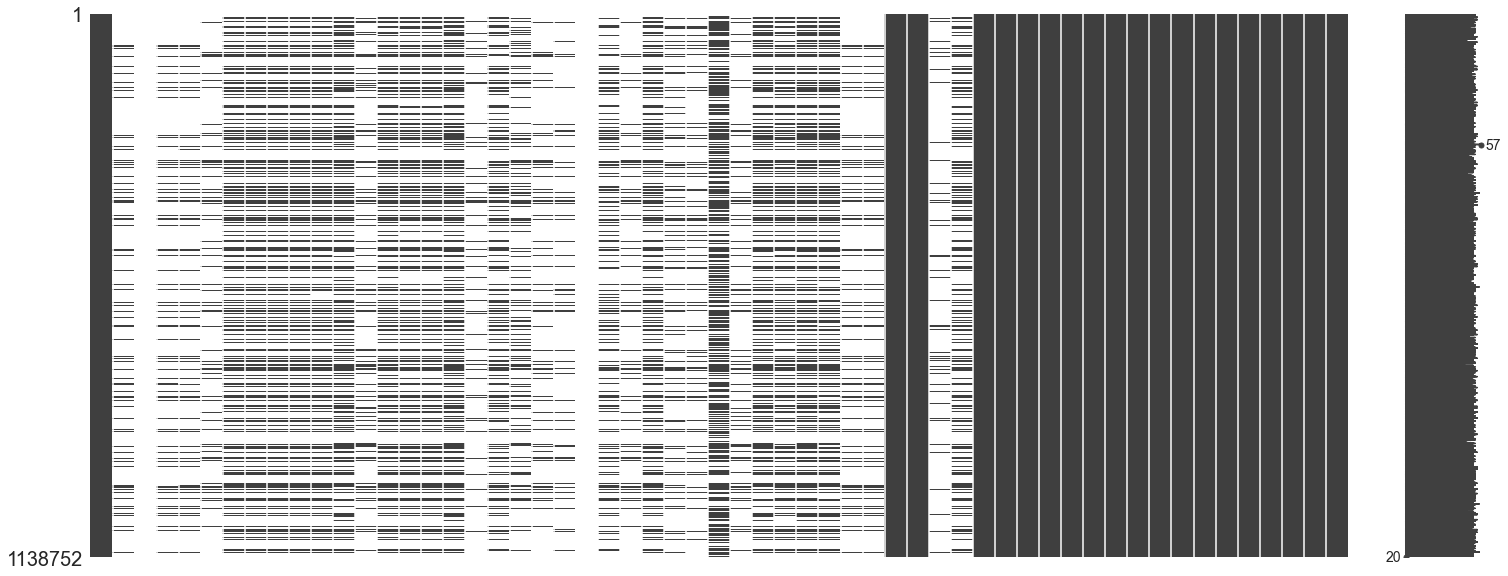

In [10]:
import missingno as msno
msno.matrix(all_df_new)

In [ ]:
bsi_stream.engineer.sbj_df.to_csv("./data_bsi_uva_old_sbj.csv",index=False)

In [ ]:
all_df_new = pd.concat( [bsi_stream.engineer.train_df, bsi_stream.engineer.valid_df], axis=0)
all_df_new = pd.concat( [all_df_new, bsi_stream.engineer.test_df], axis=0)
import missingno as msno
#msno.matrix(all_df_new)

In [ ]:
# nbc
#all_df.to_csv("./data_bsi_txp_4d_nbc.csv",index=False)
# bc
#all_df.to_csv("./data_bsi_txp_4d_bc.csv",index=False)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

In [ ]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'
# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case_txp'

In [ ]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

In [ ]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=2*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=24*60, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

In [ ]:
print(bsi_stream.engineer.episode)

In [ ]:
# Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
bsi_stream.engineer.BuildMVTS(csv_pool_path, 
                              nsbj = 6000, # number of subjects / patients to sample from the pool 
                              replace=False, # sample with replacement or not 
                              valid_frac = 0.2, # fraction of number of subjects in validation dataset
                              test_frac = 0.1, # fraction of number of subjects in left-out test dataset
                              batch_size = 64, # batch size (usually 32,64,128..)
                              impute_input='median', # imputation on predictors
                              impute_output='median',
                              sep="_")# imputation on response (no need in BSI project)
# please see the end of console 
# --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

In [ ]:
all_df = pd.concat( [bsi_stream.engineer.train_df, bsi_stream.engineer.valid_df], axis=0)
all_df = pd.concat( [all_df, bsi_stream.engineer.test_df], axis=0)
print(len(set(all_df.__uid)))
all_df.describe()

In [ ]:
from random import randint
import matplotlib.pylab as plt 
import numpy as np
from tensorflow.keras.models import Sequential, Model

def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,1,0))




def plot_features_map(input_image_list, 
                      cnn,
                      img_title_list,
                      layer_idx):
    
    nrow = len(layer_idx)
    ncol = len(input_image_list)
    
    fig, ax = plt.subplots(nrow+1, ncol, figsize=(20,20))
    
    for j in range(ncol):
        input_image = input_image_list[j]
        ax[0][j].imshow(input_image[:,:,0].transpose(1,0))
        ax[0][j].set_title(img_title_list[j])
        for i in range(nrow):
            feature_map = get_feature_maps(cnn, layer_idx[i], input_image)
            ax[i+1][j].imshow(feature_map[0,:,:])
            ax[i+1][j].set_title('layer {} - {}'.format(layer_idx[i], cnn.layers[layer_idx[i]].get_config()['name']))

    return

## setup

In [ ]:
# csv pool folder directory
csv_pool_path = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/csv_pool'


# current experiment working directory
work_dir = '/Users/jiaxingqiu/Documents/CAMA_projects/BSI/code/projects/case4'

In [ ]:
# initiate a FAIRStream object instance for BSI project
bsi_stream = FAIRStream.FAIRStream(work_dir)
# take a look at dictionaries in engineer's hands
#bsi_stream.engineer.csv_source_dict
bsi_stream.engineer.variable_dict

## Define Episode

In [ ]:
# define an episode (notice that the engineer now has new attributes)
bsi_stream.engineer.DefineEpisode(input_time_len=4*24*60, # using vital signs and labs 4 days prior to a culture 
                                  output_time_len=1, # predict one time unit into the future
                                  time_resolution=60, # aggregate minutely data to one row per hour 
                                  time_lag=0,  # no time lag between predictors and response
                                  anchor_gap=7*24*60) # the minimum distance between two episodes

## Build MVTS (multi-variable time series) data objects
- train_df_imputed, valid_df_imputed and test_df_imputed are dataframes
- train_tfds, valid_tfds and test_tfds are tensorflow datasets

In [ ]:
# # Build MVTS dataframe or tfds  (notice that the engineer now has new attributes)
# bsi_stream.engineer.BuildMVTS(csv_pool_path, 
#                               nsbj = 10, # number of subjects / patients to sample from the pool 
#                               valid_frac = 0.2, # fraction of number of subjects in validation dataset
#                               test_frac = 0.1, # fraction of number of subjects in left-out test dataset
#                               batch_size = 64, # batch size (usually 32,64,128..)
#                               impute_input='median', # imputation on predictors
#                               impute_output='median' )# imputation on response (no need in BSI project)

# # please see the end of console 
# # --- Success! Engineer has updated attributes --- train_df_imputed, valid_df_imputed and test_df_imputed. 
# # --- Success! Engineer has updated attributes --- train_tfds, valid_tfds and test_tfds. 

### print all the attributes of the engineer

In [ ]:
# bsi_stream.engineer.info()

# # extract X, Y numpy array by engineer build-in function
# X_train, Y_train, X_valid, Y_valid, X_test, Y_test = bsi_stream.engineer.ExtractXY()

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_valid = X_valid.astype('float32')
# X_test = X_test.astype('float32')

# Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[2])
# Y_valid = Y_valid.reshape(Y_valid.shape[0], Y_valid.shape[2])
# Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[2])

# X_all = np.concatenate((X_train, X_valid, X_test), axis=0)
# Y_all = np.concatenate((Y_train, Y_valid, Y_test), axis=0)


In [ ]:
# specify input column names
bsi_stream.engineer.input_vars = ['age___vital', 'age___lab', 'temp___vital', 'heart_rate___vital', 'systolic_blood_pressure___vital', 'diastolic_blood_pressure___vital', 'resp_rate___vital', 'glucose___vital', 'bilirubin___vital', 'potassium___vital', 'albumin___vital', 'calcium___vital', 'wbc___vital', 'creatinine___vital', 'platelet_count___vital', 'alt___vital', 'alp___vital', 'ast___vital', 'paco2___vital', 'chloride___vital', 'troponin___vital', 'ptt___vital', 'lactate___vital', 'bun___vital', 'magnesium___vital']


## --- Pre-modeling Interpretability (raw scale) ---

In [ ]:
X_all = np.load("./X_all.npy")
Y_all = np.load("./Y_all.npy")
X_train = np.load("./X_train.npy")
Y_train = np.load("./Y_train.npy")
X_valid = np.load("./X_valid.npy")
Y_valid = np.load("./Y_valid.npy")
X_test = np.load("./X_test.npy")
Y_test = np.load("./Y_test.npy")

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)

X_pos = X_all[Y_all[:,1]==1.0][:,:,:,0]
X_ctrl = X_all[Y_all[:,1]==0.0][:,:,:,0]
print("X_pos shape", X_pos.shape)
print("X_ctrl shape", X_ctrl.shape)


### 1. print a few episode as images

In [ ]:
fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10): 
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0,  # change zero to be not white 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_pos[i], cmap='bwr', norm=norm)
    axes[i].set_title('postive episode {}'.format(i))

fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10):
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0, 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_ctrl[i], cmap='bwr', norm=norm)
    axes[i].set_title('control episode {}'.format(i))

### 2. Visualize Statistical Moments -- Positive VS Control Group

#### Statistic Moment 1 -- mean

In [ ]:
# outlier in image

In [ ]:
X_pos_stat = X_pos.mean(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.mean(axis=0).transpose((1,0))
X_all_stat = X_all.mean(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()

im = ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[1])

im = ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[2])


#### Statistic Moment 2 -- std

In [ ]:
X_pos_stat = X_pos.std(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.std(axis=0).transpose((1,0))
X_all_stat = X_all.std(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])


#### Statistic Moment 3 -- skewness

In [ ]:
X_pos_stat = scipy.stats.skew(X_pos, axis=0).transpose((1,0))
X_ctrl_stat = scipy.stats.skew(X_ctrl, axis=0).transpose((1,0))
X_all_stat = scipy.stats.skew(X_all, axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])

#### Statistic Moment 4 -- Kurtosis

In [ ]:
X_pos_stat = scipy.stats.kurtosis(X_pos, axis=0).transpose((1,0))
X_ctrl_stat = scipy.stats.kurtosis(X_ctrl, axis=0).transpose((1,0))
X_all_stat = scipy.stats.kurtosis(X_all, axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])

## --- Modeling interpretation raw scale (CNN) ---

In [ ]:
X_train_2d = X_train[:,:,:,0].reshape(X_train[:,:,:,0].shape[0],-1)
X_valid_2d = X_valid[:,:,:,0].reshape(X_valid[:,:,:,0].shape[0],-1)
Y_train_binary = Y_train[:,1]
Y_valid_binary = Y_valid[:,1]
print(X_train_2d.shape)
print(Y_train_binary.shape)
print(X_valid_2d.shape)
print(Y_valid_binary.shape)

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear').fit(X_train_2d, Y_train_binary)

#to check the shape of the coefficient matrix
clf.coef_.shape

In [ ]:
scale = np.max(np.abs(clf.coef_))

p = plt.figure(figsize=(25, 25));
nclasses=1
for i in range(nclasses):
    p = plt.subplot(1, nclasses, i + 1)
    p = plt.imshow(clf.coef_[i].reshape(96, 25).T,
                  cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
    p = plt.axis('off')
    p = plt.title('positive');

### AUROC for logistic regression

In [ ]:
Y_valid_pred = clf.predict_proba(X_valid_2d)
sklearn.metrics.roc_auc_score(Y_valid_binary, Y_valid_pred[:,1])

### binary setup logistic regression

In [ ]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC'),
    keras.metrics.AUC(name='AUPRC', curve='PR')
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=list(X_train.shape)[1:4]),
    keras.layers.Dense(1, activation='sigmoid')
])
mdl.summary()
mdl.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(X_train, Y_train_binary, 
              epochs=50, 
              validation_data=(X_valid,Y_valid_binary), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train_binary, 
              epochs=50, 
              validation_data=(X_valid,Y_valid_binary), callbacks=[callback])

### multiple classification setup logistic regression

In [ ]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
    #keras.metrics.recall(....),
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Flatten(input_shape=list(X_train.shape)[1:4]),
    keras.layers.Dense(2, activation='softmax')
])
mdl.summary()
mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

In [ ]:
myMetrics = [
    keras.metrics.AUC(name='AUROC', curve='ROC', multi_label=True),
    keras.metrics.AUC(name='AUPRC', curve='PR', multi_label=True),
    keras.metrics.recall(....),
]

keras.backend.clear_session()
mdl = keras.models.Sequential([
    keras.layers.Conv2D(64, 
                        kernel_size=(3,3),
                        activation='relu', 
                        padding='same',
                        input_shape=list(X_train.shape)[1:4]),
    keras.layers.MaxPool2D(pool_size=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, 
                        kernel_size=(3,3),
                        activation='relu', 
                        padding='same'),
    keras.layers.MaxPool2D(pool_size=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(1, 
                        kernel_size=(3,3),
                        activation='relu', 
                        padding='same'),
    keras.layers.MaxPool2D(pool_size=(1,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
mdl.summary()
mdl.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics = myMetrics)
callback = EarlyStopping(monitor='val_loss', patience=5)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])
keras.backend.set_value(mdl.optimizer.learning_rate, 1e-4)
his = mdl.fit(X_train, Y_train, 
              epochs=50, 
              validation_data=(X_valid,Y_valid), callbacks=[callback])

In [ ]:
X_train_pos_img = X_train[Y_train[:,0]==1.0].mean(axis=0)
X_train_ctrl_img = X_train[Y_train[:,0]==0.0].mean(axis=0)

X_valid_pos_img = X_valid[Y_valid[:,0]==1.0].mean(axis=0)
X_valid_ctrl_img = X_valid[Y_valid[:,0]==0.0].mean(axis=0)

X_all_pos_img = X_all[Y_all[:,0]==1.0].mean(axis=0)
X_all_ctrl_img = X_all[Y_all[:,0]==0.0].mean(axis=0)

plot_features_map(input_image_list=[X_all_pos_img, X_all_ctrl_img,
                                    X_train_pos_img, X_train_ctrl_img, 
                                    X_valid_pos_img, X_valid_ctrl_img],
                  img_title_list=["POS (all)", "CTRL (all)",
                                  "POS (train)", "CTRL (train)", 
                                  "POS (valid)", " CTRL (valid)"],
                  layer_idx=[0,3,6], 
                  cnn=mdl)

## --- Post-Modeling interpretation (raw scale + saliency map) ---

In [ ]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
def plot_saliency(img_idx):
    grads = visualize_saliency(mdl,
                               "visualized_layer",
                               filter_indices=Y_all[img_idx][0], 
                               seed_input=X_all[img_idx], 
                               backprop_modifier=None,
                               grad_modifier="absolute")
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(X_all[img_idx])
    ax[0].set_title('original img id {}'.format(img_idx))
    ax[1].imshow(grads, cmap='jet')
    ax[1].set_title('saliency - predicted {}'.format(img_idx))

plot_saliency(img_idx = 0)

## --- Pre-training Interpretability (standardized) ---

In [ ]:
X_all = np.load("./X_all.npy")
Y_all = np.load("./Y_all.npy")
X_train = np.load("./X_train.npy")
Y_train = np.load("./Y_train.npy")
X_valid = np.load("./X_valid.npy")
Y_valid = np.load("./Y_valid.npy")
X_test = np.load("./X_test.npy")
Y_test = np.load("./Y_test.npy")

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)

X_train = (X_train - X_all.mean(axis=0))/X_all.std(axis=0)
X_valid = (X_valid - X_all.mean(axis=0))/X_all.std(axis=0)
X_all = (X_all - X_all.mean(axis=0))/X_all.std(axis=0)

print("X_train shape", X_train.shape)
print("Y_train shape", Y_train.shape)
print("X_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("X_all shape", X_all.shape)
print("Y_all shape", Y_all.shape)


X_pos = X_all[Y_all[:,1]==1.0][:,:,:,0]
X_ctrl = X_all[Y_all[:,1]==0.0][:,:,:,0]
print("X_pos shape", X_pos.shape)
print("X_ctrl shape", X_ctrl.shape)


In [ ]:
fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10): 
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0, 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_pos[i], cmap='bwr', norm=norm)
    axes[i].set_title('postive episode {}'.format(i))

fig, ax = plt.subplots(1,10,figsize=(20,20))
axes = ax.flatten()
for i in range(10):
    norm = colors.TwoSlopeNorm(vmin = -np.max(np.abs(X_pos[i])), 
                               vcenter = 0, 
                               vmax = np.max(np.abs(X_pos[i])) )
    axes[i].imshow(X_ctrl[i], cmap='bwr', norm=norm)
    axes[i].set_title('control episode {}'.format(i))

#### Statistic Moment 1 -- mean

In [ ]:
X_pos_stat = X_pos.mean(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.mean(axis=0).transpose((1,0))
X_all_stat = X_all.mean(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()

im = ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[1])

im = ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12))
fig.colorbar(im, ax=ax[2])


### Statistic Moment 2 -- std

In [ ]:
X_pos_stat = X_pos.std(axis=0).transpose((1,0))
X_ctrl_stat = X_ctrl.std(axis=0).transpose((1,0))
X_all_stat = X_all.std(axis=0)[:,:,0].transpose((1,0))

norm = colors.TwoSlopeNorm(vmin = -max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ), 
                               vcenter = 0, 
                               vmax = max( np.max(np.abs(X_all_stat)),np.max(np.abs(X_pos_stat)),np.max(np.abs(X_ctrl_stat)) ) )


fig, axes = plt.subplots(3,1, figsize=(20,20))
ax = axes.flatten()
im=ax[0].imshow(X_pos_stat, cmap='bwr', norm=norm)
ax[0].set_title("Positive Episode")
ax[0].tick_params(axis='y', labelrotation=0)
ax[0].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[0].set_yticklabels(bsi_stream.engineer.input_vars);
ax[0].set_xticks(range(0,96,12))
ax[0].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[0])

im=ax[1].imshow(X_ctrl_stat, cmap='bwr', norm=norm)
ax[1].set_title("Control Group Episode")
ax[1].tick_params(axis='y', labelrotation=0)
ax[1].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[1].set_yticklabels(bsi_stream.engineer.input_vars);
ax[1].set_xticks(range(0,96,12))
ax[1].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[1])

im=ax[2].imshow(X_all_stat, cmap='bwr', norm=norm)
ax[2].set_title("Combined Episode")
ax[2].tick_params(axis='y', labelrotation=0)
ax[2].set_yticks(range(len(bsi_stream.engineer.input_vars)))
ax[2].set_yticklabels(bsi_stream.engineer.input_vars);
ax[2].set_xticks(range(0,96,12))
ax[2].set_xticklabels(range(-96,0,12));
fig.colorbar(im, ax=ax[2])

#### Statistic Moment 3 -- skewness

#### Statistic Moment 4 -- Kurtosis